## Pre-processing gridded crime data for Estonia

The dataset is provided by the Information Technology and Development Center of the Ministry of the Interior of Estonia (SMIT). SMIT is the largest IT institution in the country, which creates and manages information systems necessary for saving lives and ensuring internal security. The data contains anonymised records of crimes, felonies and other offenses against the law. The data is binned into squares of either 500mx500m or 1000mx1000m. However, when working with the datasets, issues and errors can be expected within the data and have to be dealt with to get the valuable information out.

The variables focused on: Lest_X and Lest_Y (coordinate bounds in Estonian EPSG:3301 projected coordinates) as well as the damage caused "Kahjusumma."

In [1]:
# Import necessary modules/libraries
import requests
import pandas as pd
import numpy as np
from shapely.geometry import box, LineString
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Download the data directly in Python and save it into the working folder
data_url = "https://opendata.smit.ee/ppa/csv/avalik_3.csv"
save_file_name = "avalik_3.csv"

response = requests.get(data_url)

In [3]:
# Indicate request status
print(response.status_code)

200


In [4]:
# Open & write into the downloaded content into the save_file_name
with open(save_file_name, 'wb') as f:
    f.write(response.content)

In [5]:
# Read the CSV and strip whitespace
df = pd.read_table(save_file_name).apply(lambda col: col.str.strip())
df[df == ""] = np.nan
df = df.dropna()
df.head(1)

,JuhtumId,ToimKpv,ToimKell,ToimNadalapaev,SyndmusLiik,SyndmusTaiendavStatLiik,Seadus,Paragrahv,ParagrahvTais,Loige,Kahjusumma,KohtLiik,MaakondNimetus,ValdLinnNimetus,KohtNimetus,Lest_X,Lest_Y,SyyteoLiik
0,ec4cc3fc-1635-18d5-8326-a9a756483dba,2016-12-31,23:30,Laupäev,VARGUS,MUU_VARGUS,Karistusseadustik,§ 199.,§ 199. Vargus,lg. 1.,0-499,"AVALIK_KOHT,SOOGIKOHT",Harju maakond,Tallinn,Kesklinna linnaosa,6588500-6588999,542000-542499,KT


In [6]:
# Select the columns of interest
df = df.loc[:, ['Kahjusumma', 'Lest_X', 'Lest_Y']]
df.head(2)

,Kahjusumma,Lest_X,Lest_Y
0,0-499,6588500-6588999,542000-542499
5,500-4999,6589000-6589499,542000-542499


### The location information in the "Kahjusumma	" column is encoded in square grid cells, with either 500m or 1000m side length (min-max).
### The next step is to extract the coordinate values and build square polygons for each row.

In [7]:
# Functions to split and obtain min_x, max_x, min_y and max_y for each row

def split_min_x(row):
    ''' This function splits string coordinates and returns the min x coordinate '''
    try:
        split_lest = row['Lest_X'].split('-')
        min_x = split_lest[0]
        return min_x
    except:
        pass

def split_max_x(row):
    ''' This function splits string coordinates and returns the max x coordinate '''
    try:
        split_lest = row['Lest_X'].split('-')
        max_x = split_lest[1]
        return max_x
    except:
        pass
    
def split_min_y(row):
    ''' This function splits string coordinates and returns the min y coordinate '''
    try:
        split_lest = row['Lest_Y'].split('-')
        min_y = split_lest[0]
        return min_y
    except:
        pass
    
def split_max_y(row):
    ''' This function splits string coordinates and returns the max y coordinate '''
    try:
        split_lest = row['Lest_Y'].split('-')
        max_y = split_lest[1]
        return max_y
    except:
        pass

In [8]:
#create the min_x, max_x, min_y and max_y columns
df['min_x'] = pd.to_numeric(df.apply(split_min_x, axis=1))
df['max_x'] = pd.to_numeric(df.apply(split_max_x, axis=1))
df['min_y'] = pd.to_numeric(df.apply(split_min_y, axis=1))
df['max_y'] = pd.to_numeric(df.apply(split_max_y, axis=1))
df.head(2)

,Kahjusumma,Lest_X,Lest_Y,min_x,max_x,min_y,max_y
0,0-499,6588500-6588999,542000-542499,6588500,6588999,542000,542499
5,500-4999,6589000-6589499,542000-542499,6589000,6589499,542000,542499


### Use shapely box function to build a geometry polygon for each row

In [9]:
# Create geometry using a box
def create_box(row):
    ''' This function takes 4 coordinates and creates a box '''
    crime_box = box(row['min_y'], row['min_x'], row['max_y'], row['max_x'])
    return crime_box

In [10]:
# create a geometry column
df['geometry'] = df.apply(create_box, axis=1)
df.head(2)

,Kahjusumma,Lest_X,Lest_Y,min_x,max_x,min_y,max_y,geometry
0,0-499,6588500-6588999,542000-542499,6588500,6588999,542000,542499,"POLYGON ((542499 6588500, 542499 6588999, 5420..."
5,500-4999,6589000-6589499,542000-542499,6589000,6589499,542000,542499,"POLYGON ((542499 6589000, 542499 6589499, 5420..."


### Extract the damage sum and the average of the described damage range

In [11]:
# functions to split and obtain kahjusumma (damage) data sum and average
def kahjusumma_sum (row):
    ''' This function splits  "Kahjusumma" row values and returns their sum'''
    try:
        split_kahj = row['Kahjusumma'].split('-')
        min_kahj = split_kahj[0]
        max_kahj = split_kahj[1]
        kahj_sum = (float(min_kahj) + float(max_kahj))
        return kahj_sum
    except:
        pass   
    
def avg_kahjusumma(row):
    ''' This function splits  "Kahjusumma" row values and returns their average'''
    try:
        split_kahj = row['Kahjusumma'].split('-')
        min_kahj = split_kahj[0]
        max_kahj = split_kahj[1]
        kahj_average = (float(min_kahj) + float(max_kahj)) / 2
        return kahj_average
    except:
        pass  


In [12]:
# create the damage sum and average columns
df['kahj_sum'] = pd.to_numeric(df.apply(kahjusumma_sum, axis=1))
df['kahj_average'] = pd.to_numeric(df.apply(avg_kahjusumma, axis=1))
df.head(2)

,Kahjusumma,Lest_X,Lest_Y,min_x,max_x,min_y,max_y,geometry,kahj_sum,kahj_average
0,0-499,6588500-6588999,542000-542499,6588500,6588999,542000,542499,"POLYGON ((542499 6588500, 542499 6588999, 5420...",499.0,249.5
5,500-4999,6589000-6589499,542000-542499,6589000,6589499,542000,542499,"POLYGON ((542499 6589000, 542499 6589499, 5420...",5499.0,2749.5


### Plot to see the spatial spread

In [13]:
# Creating a geodataframe  from the df
gdf = gpd.GeoDataFrame(df, crs=3301)

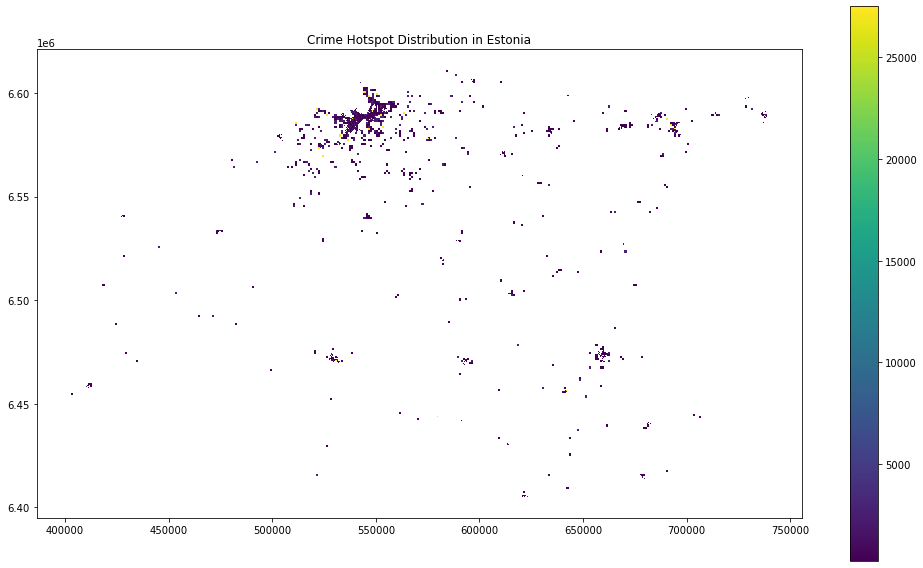

In [14]:
#  Plot the crime hotspots
fig, ax = plt.subplots(figsize = (14,8))
gdf.plot(gdf['kahj_average'], ax=ax, linewidth=0.055, legend=True)
plt.title('Crime Hotspot Distribution in Estonia')
plt.savefig('crime_hotspots.png', facecolor='w')
plt.tight_layout()

### Summarize damages per same area